# Fitting Background and Signal
Much like in the rare mode case we need analytical models that describe the shape of the background and signal mass distributions respectively.

In [2]:
import os
os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import callbacks
import zfit 
from zfit import z
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

2022-04-01 15:55:11.819438: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-01 15:55:11.819469: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df = pd.read_csv('../data_files/8.0.4/all.csv', index_col=[0])
bg = df['Lb_M'][df['category']==0].to_numpy()
# After inspecting the distribution it weirdly dies off after 4800 MeV, probably because of the preselection
bg = bg[bg > 4800]

jpsi_qsqr_veto = (3000, 3178)
sg = df['Lb_M'][np.logical_and(df['category']==1, df['QSQR'].between(*jpsi_qsqr_veto))].to_numpy()

## Plot Distributions

In [64]:
def plotMass(masses, nbins, labels, yerr=True, density=False, zoom=None, save=None):
    masses_flat = np.concatenate(masses)
    bins = np.linspace(np.min(masses_flat), np.max(masses_flat), nbins)
    
    fig, ax = plt.subplots(1, 1)
    hs = []
    for mass in masses:
        hs.append(np.histogram(mass, bins=bins, density=density)[0])
    if density:
        yerr = False
    hep.histplot(hs, yerr=yerr, bins=bins, ax=ax, label=labels)
    if zoom is not None:
        ax.set_xlim(*zoom)
    ax.set_xlabel(r'Mass $MeV/c^2$')
    plt.legend()
    ax.set_ylabel('Candidates')
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    return fig, ax

In [63]:
def plotFit(mass, model, label, zoom=None, save=None):
    fig, ax = plt.subplots(1, 1)
    allLimits = [mass.data_range.limit1d[0], mass.data_range.limit1d[1]]
    allLimits = np.array(allLimits)

    xBins = np.linspace(np.amin(allLimits), np.amax(allLimits), num=200)
    x = (xBins[1:]+xBins[:-1]) / 2
    y=np.array([])

    nBinsLimit=0
    for a in range(int(allLimits.shape[0]/2)):
        nBinsLimit+=len(x[(x>allLimits[a*2])&(x<allLimits[a*2+1])])
        
    y = np.append(y, model.pdf(x) * mass.nevents.numpy() / nBinsLimit * np.sum(allLimits[1::2]-allLimits[::2]))
    y *= 1

    data_plot = zfit.run(z.unstack_x(mass))
    a = ax.hist(data_plot, bins=xBins,label=mass.space.obs[0])
    scaledDiff=(a[0][a[0]!=0]-y[a[0]!=0])/np.sqrt(a[0][a[0]!=0])
    print("Chi2 = %.2g"%(np.sum(scaledDiff**2)/(len(scaledDiff)-len(model.get_params()))))
        
    ax.plot(x, y, label=label)
    if zoom is not None:
        ax.set_xlim(*zoom)
    ax.set_xlabel(r'Mass $MeV/c^2$')
    ax.set_ylabel('Candidates')
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()

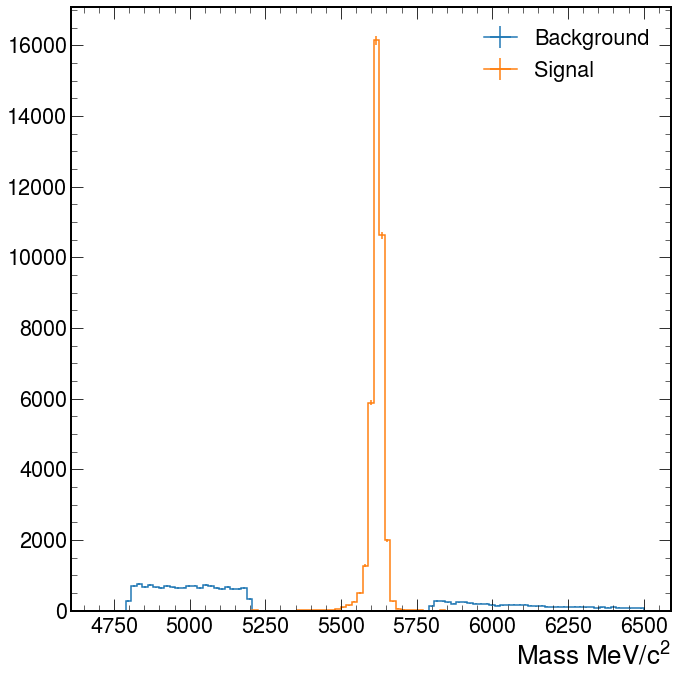

In [60]:
fig, ax = plotMass([bg, sg], 100, ['Background', 'Signal'], density=False)

## Fitting Signal

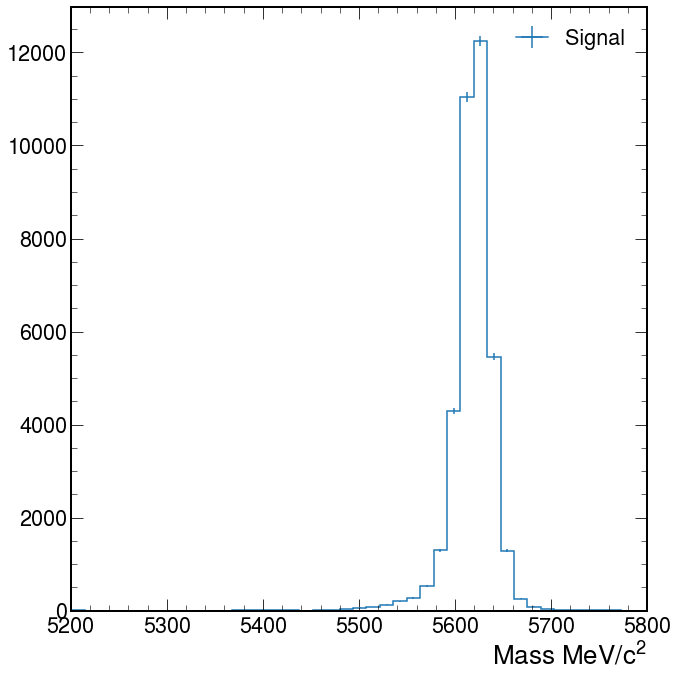

In [61]:
fig, ax = plotMass([sg], 100, ['Signal'], zoom=(5200, 5800))

In [55]:
def fitSignal(np_data, label, param_ranges, mass_ranges=[4800, 6500]):
    massObs = zfit.Space("Lb_M", limits=(mass_ranges[0], mass_ranges[1]))
    LbM = zfit.Data.from_numpy(obs=massObs, array=np_data)
    
    mu_CB = zfit.Parameter(f'mu_CB_{label}', *param_ranges[0])
    sigma_CB = zfit.Parameter(f'sigma_CB_{label}', *param_ranges[1])
    alpha_l = zfit.Parameter(f'alpha_l_{label}', *param_ranges[2])
    n_l = zfit.Parameter(f'n_l_{label}', *param_ranges[3])
    alpha_r = zfit.Parameter(f'alpha_r_{label}', *param_ranges[4])
    n_r = zfit.Parameter(f'n_r_{label}', *param_ranges[5])
    
    doubleCB = zfit.pdf.DoubleCB(obs=massObs, mu=mu_CB, sigma=sigma_CB, alphal=alpha_l, alphar=alpha_r, nr=n_r, nl=n_l)
    nyield = zfit.Parameter(f'yield_{label}', *param_ranges[6], step_size=1)
    doubleCB_yield = doubleCB.create_extended(nyield)
    
    nll_ext_dcb = zfit.loss.ExtendedUnbinnedNLL(doubleCB_yield, LbM)
    minimizerDCB = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult = minimizerDCB.minimize(nll_ext_dcb)
    
    return doubleCB_yield, fitResult, LbM

In [48]:
signal_model, signal_result, smasses = fitSignal(sg, [[5600, 5500, 5700],[20, 10, 50],[1, 0, 2],[4, 0.1, 10],[1, 0, 2],[4, 0.1, 10],[30000, 0, 100000]])

2022-04-01 16:19:33.521040: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-01 16:19:33.521107: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-01 16:19:33.521169: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eprexb.ph.bham.ac.uk): /proc/driver/nvidia/version does not exist
2022-04-01 16:19:33.522275: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 16:19:33.618173: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of th

In [49]:
signal_result.converged, signal_result.valid

(True, False)

In [52]:
param_errors = signal_result.errors()
print(signal_result.params)

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/minimizers/fitresult.py:1115: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


name        value         minuit_minos    at limit
--------  -------  -------------------  ----------
yield          10  -0.00013   +4.6e-11        True
alpha_l     1.419  -  0.025   +  0.026       False
alpha_r     1.977  -  0.053   +  0.023       False
mu_CB        5621  -  0.097   +  0.096       False
n_l         3.636  -   0.13   +   0.14       False
n_r         4.122  -   0.26   +   0.35       False
sigma_CB    14.26  -   0.11   +    0.1       False


Chi2 = 3


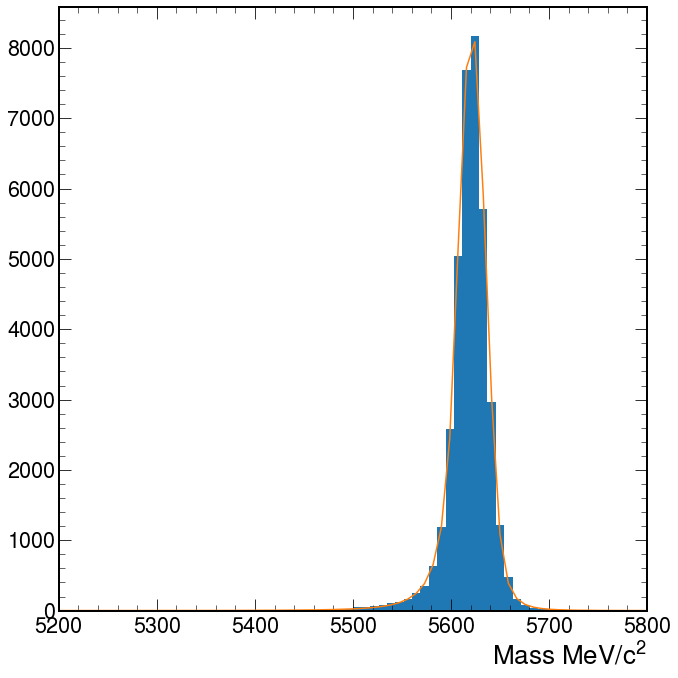

In [62]:
plotFit(smasses, signal_model, 'DCB', zoom=(5200, 5800))

## Fitting Background

In [67]:
class MyPoly(zfit.pdf.ZPDF):
    """ A third order polynomial """
    _N_OBS = 1
    _PARAMS = ['p0', 'p1', 'p2', 'p3']
    
    def _unnormalized_pdf(self, x):
        x = z.unstack_x(x)
        p0 = self.params['p0']
        p1 = self.params['p1']
        p2 = self.params['p2']
        p3 = self.params['p3']
        
        return p3*(x-p0)**3 + p2*(x-p0)**2 + p1*(x-p0)
    
def poly_integral_from_any_to_any(limits, params, model):
    p3 = params['p3']
    p2 = params['p2']
    p1 = params['p1']
    p0 = params['p0']
    
    (lower,), (upper,) = limits.limits
    ll = (3*p3)*(lower-p0)**2 + (2*p2)*(lower-p0) + p1
    ul =  (3*p3)*(upper-p0)**2 + (2*p2)*(upper-p0) + p1
    
    return ul - ll

limits = zfit.Space.from_axes(axes=0, limits=(zfit.Space.ANY_LOWER, zfit.Space.ANY_UPPER))
MyPoly.register_analytic_integral(func=poly_integral_from_any_to_any, limits=limits)

In [69]:
def fitBg(np_data, label, param_ranges, mass_ranges=[4800, 6500]):
    massObs = zfit.Space("Lb_M", limits=(mass_ranges[0], mass_ranges[1]))
    LbM = zfit.Data.from_numpy(obs=massObs, array=np_data)
    
    p0 = zfit.Parameter(f'p0_{label}', *param_ranges[0])
    p1 = zfit.Parameter(f'p1_{label}', *param_ranges[1])
    p2 = zfit.Parameter(f'p2_{label}', *param_ranges[2])
    p3 = zfit.Parameter(f'p3_{label}', *param_ranges[3])
    
    poly = MyPoly(obs=massObs, p0=p0, p1=p1, p2=p2, p3=p3)
    
    poly_yield = zfit.Parameter(f'yield_{label}', *param_ranges[4], step_size=1)
    poly_ext = poly.create_extended(poly_yield)
    
    nll_ext_dcb = zfit.loss.ExtendedUnbinnedNLL(poly_ext, LbM)
    minimizerDCB = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult = minimizerDCB.minimize(nll_ext_dcb)
    
    return poly_ext, fitResult, LbM

In [5]:
bg_model, bg_result, bg_obs = fitBg(bg, '1', [[4780, 4600, 4900], [300, 200, 1000], [0.0018, 0.0, 0.0025], [30000, 0, 100000]])

2022-04-01 15:36:20.987750: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-01 15:36:20.987814: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-01 15:36:20.987860: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eprexb.ph.bham.ac.uk): /proc/driver/nvidia/version does not exist
2022-04-01 15:36:20.988879: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/core/basepdf.py:442: UserWarning: As 

In [6]:
result.converged, result.valid

(True, False)

In [7]:
param_errors = result.errors()
print(result.params)

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/minimizers/fitresult.py:1115: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


name        value         minuit_minos    at limit
------  ---------  -------------------  ----------
yield       20140  -1.4e+02   +1.4e+02       False
mu_g         4600  -3.8e-05   +   0.27        True
s_g         817.4  -    5.1   +    5.3       False
lam     1.035e-10  -  1e-10   +4.1e-07        True


Chi2 = 74


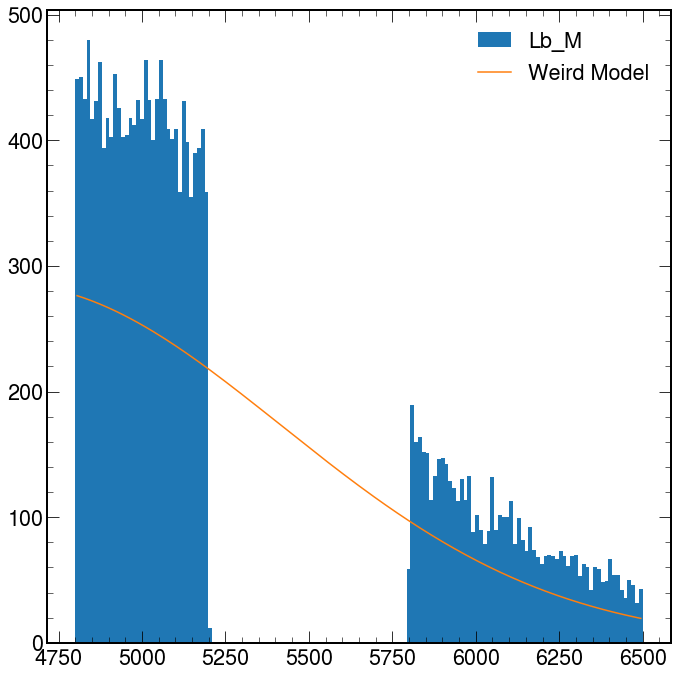

In [8]:
x = np.linspace(4800, 6500, 200)
fig, ax = plt.subplots(1, 1)
h, bins = np.histogram(masses, bins=100)
#hep.histplot(h, yerr=True, bins=bins, ax=ax, label='Normalisation')

allLimits = [obs.data_range.limit1d[0], obs.data_range.limit1d[1]]
allLimits = np.array(allLimits)

xBins = np.linspace(np.amin(allLimits), np.amax(allLimits), num=150)
x = (xBins[1:]+xBins[:-1]) / 2
y=np.array([])

nBinsLimit=0
for a in range(int(allLimits.shape[0]/2)):
    nBinsLimit+=len(x[(x>allLimits[a*2])&(x<allLimits[a*2+1])])
    
y = np.append(y, model.pdf(x) * obs.nevents.numpy() / nBinsLimit * np.sum(allLimits[1::2]-allLimits[::2]))
y *= 1

data_plot = zfit.run(z.unstack_x(obs))
a = ax.hist(data_plot, bins=xBins,label=obs.space.obs[0])
scaledDiff=(a[0][a[0]!=0]-y[a[0]!=0])/np.sqrt(a[0][a[0]!=0])
print("Chi2 = %.2g"%(np.sum(scaledDiff**2)/(len(scaledDiff)-len(model.get_params()))))
    
ax.plot(x, y, label='Weird Model')
#ax.plot(x, product(x, -10, -16, 0.0018, 4780, 300, -420))
plt.tight_layout()
plt.legend()
plt.show()